In [1]:
using ReactiveMP
using Distributions
using Random
using BenchmarkTools
using Rocket
using GraphPPL
using Parameters

Here is an example of creating custom node with nonlinear function approximation with samplelist.

### Custom node creation

In [2]:
struct NonlinearNode end # Dummy structure just to make Julia happy

struct NonlinearMeta{F}
    fn       :: F   # Nonlinear function, we assume 1 float input - 1 float ouput
    nsamples :: Int # Number of samples used in approximation
end

In [3]:
@node NonlinearNode Deterministic [ out, in ]

We need to define two Sum-product message computation rules for our new custom node
- Rule for outbound message on `out` edge given inbound message on `in` edge
- Rule for outbound message on `in` edge given inbound message on `out` edge
- Both rules accept optional meta object

In [4]:
# Rule for outbound message on `out` edge given inbound message on `in` edge
@rule NonlinearNode(:out, Marginalisation) (m_in::NormalMeanVariance, meta::NonlinearMeta) = begin 
    samples = rand(m_in, meta.nsamples)
    return SampleList(map(meta.fn, samples))
end

In [5]:
# Rule for outbound message on `in` edge given inbound message on `out` edge
@rule NonlinearNode(:in, Marginalisation) (m_out::Gamma, meta::NonlinearMeta) = begin     
    return ContinuousUnivariateLogPdf((x) -> logpdf(m_out, meta.fn(x)))
end

### Model specification

After we have defined our custom node with custom rules we may proceed with a model specification:
$$
\begin{equation}
\begin{aligned}
p(\theta) &= \mathcal{N}(\theta|\mu_{\theta}, \sigma_{\theta}),\\
p(m) &= \mathcal{N}(\theta|\mu_{m}, \sigma_{m}),\\
p(w) &= f(\theta),\\
p(y_i|m, w) &= \mathcal{N}(y_i|m, w),
\end{aligned}
\end{equation}
$$

Given this IID model, we aim to estimate the precision of a Gaussian distribution. We pass a random variable $\theta$ through a non-linear transformation $f$ to make it positive and suitable for a precision parameter of a Gaussian distribution. We, later on, will estimate the posterior of $\theta$. 

In [17]:
@model function nonlinear_estimation(n)
    
    θ ~ NormalMeanVariance(0.0, 100.0)
    m ~ NormalMeanVariance(0.0, 1.0)
    
    w ~ NonlinearNode(θ)
    
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanPrecision(m, w)
    end
    
    return θ, m, w, y
end

In [18]:
@constraints function nconstsraints(nsamples)
    q(θ) :: SampleList(nsamples, LeftProposal())
    q(w) :: SampleList(nsamples, RightProposal())
    
    q(θ, w, m) = q(θ)q(m)q(w)
end

nconstsraints (generic function with 1 method)

In [29]:
# TODO: check
@meta function nmeta(fn, nsamples)
    NonlinearNode(θ) -> NonlinearMeta(fn, nsamples)
end

nmeta (generic function with 1 method)

Here we generate some data

In [30]:
function nonlinear_fn(x) # We use exp as a simple example
    return exp(x + 2)
end

nonlinear_fn (generic function with 1 method)

In [31]:
seed = 123
rng  = MersenneTwister(seed)

niters   = 15 # Number of VMP iterations
nsamples = 5_000 # Number of samples in approximation

n = 1000 # Number of IID samples
μ = -10.0
θ = -3.0
w = nonlinear_fn(θ)


data = rand(rng, NormalMeanPrecision(μ, w), n);

In [32]:
@time result = inference(model = Model(nonlinear_estimation, n),
                         meta =  nmeta(nonlinear_fn, nsamples),
                         constraints = nconstsraints(nsamples),
                         data=Dict(:y => data), 
                         initmarginals=Dict(:m => vague(NormalMeanPrecision), :w => vague(Gamma)),
                         iterations=niters, showprogress=true);

θposterior = result.posteriors[:θ];

  0.132348 seconds (810.32 k allocations: 50.547 MiB, 55.75% compilation time)


In [46]:
using Plots

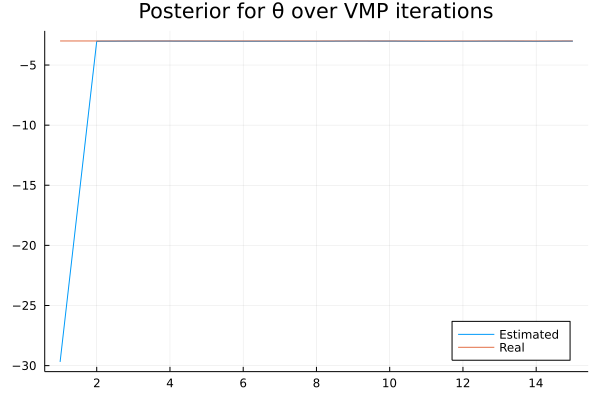

In [48]:
plot(mean.(θposterior), ribbon=std.(θposterior), title="Posterior for θ over VMP iterations", label = "Estimated", legend = :bottomright)
plot!(fill(θ, niters), label = "Real")

In [49]:
@benchmark inference(model = Model($nonlinear_estimation, $n),
                     meta =  nmeta($nonlinear_fn, $nsamples),
                     constraints = nconstsraints($nsamples),
                     data=Dict(:y => $data), 
                     initmarginals=Dict(:m => vague(NormalMeanPrecision), :w => vague(Gamma)),
                     iterations=$niters, showprogress=true)

BenchmarkTools.Trial: 75 samples with 1 evaluation.
 Range (min … max):  52.887 ms … 83.359 ms  ┊ GC (min … max):  0.00% … 23.14%
 Time  (median):     68.270 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   67.328 ms ±  9.176 ms  ┊ GC (mean ± σ):  12.30% ± 11.32%

      ▁▄▄█▄▁▁   ▁  ▄ █                ▁ ▄▄▁ █▄ ▁      ▁  ▁  ▁  
  ▆▁▁▆███████▆▁▆█▆▁█▆█▁▁▁▁▆▁▆▁▆▁▆▁▆▆▁▁█▆███▆██▆█▁▆▁▁▆▁█▆▆█▆▆█ ▁
  52.9 ms         Histogram: frequency by time        82.5 ms <

 Memory estimate: 43.33 MiB, allocs estimate: 686157.

In [32]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.6.0)
  CPU: Intel(R) Core(TM) i7-8559U CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
